## Import Required Libraries

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from tqdm.std import tqdm
import seaborn as sns
from sklearn.base import clone
from scipy.stats import skew
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
import os
from sklearn.model_selection import KFold
import time
warnings.filterwarnings('ignore')

## Load Preprocessed Data

Loading the cleaned and encoded data from the preprocessing notebook.

In [133]:
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
data_dir = os.path.join(notebook_dir, 'data')
print(f"Data directory: {data_dir}")

Data directory: e:\adult-income-analysis\notebook\data


In [134]:
X_train_scaled = pd.read_csv(os.path.join(data_dir, 'X_train_scaled.csv'))
X_test_scaled = pd.read_csv(os.path.join(data_dir, 'X_test_scaled.csv'))
y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))['income']
y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))['income']

### Support Vector Machine

#### Main Function of MODEL

In [ ]:
def main(data_dir, model=None, cv_splits=10):
    X_train_scaled = pd.read_csv(os.path.join(data_dir, 'X_train_scaled.csv'))
    X_test_scaled = pd.read_csv(os.path.join(data_dir, 'X_test_scaled.csv'))
    y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))['income']
    y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))['income']

    if model is None:
        model = LinearSVC(dual=False, random_state=3327, max_iter=5000)
    
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=3327)
    train_scores = []
    val_scores = []
    
    start = time.time()
    
    for i, (train_idx, val_idx) in enumerate(tqdm(kf.split(X_train_scaled), total=cv_splits, desc="CV Folds", ncols=80)):
        X_tr, X_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clf = clone(model)
        clf.fit(X_tr, y_tr)
        
        y_train_pred_fold = clf.predict(X_tr)
        train_acc = accuracy_score(y_tr, y_train_pred_fold)
        train_scores.append(train_acc)
        
        y_val_pred = clf.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_scores.append(val_acc)
        
        print(f"  Fold {i+1}: Train={train_acc:.4f} (green), Val={val_acc:.4f} (red)")

    cv_time = time.time() - start

    final_model = clone(model)
    final_model.fit(X_train_scaled, y_train)
    
    y_train_pred = final_model.predict(X_train_scaled)
    y_test_pred = final_model.predict(X_test_scaled)
    
    y_test_scores = final_model.decision_function(X_test_scaled)
    y_train_scores = final_model.decision_function(X_train_scaled)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    
    train_prec = precision_score(y_train, y_train_pred, zero_division=0)
    train_rec = recall_score(y_train, y_train_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    gap = train_acc - test_acc
    cv_mean_train = np.mean(train_scores)
    cv_mean_val = np.mean(val_scores)
    cv_gap = cv_mean_train - cv_mean_val
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    ax1 = axes[0, 0]
    folds = np.arange(1, len(train_scores)+1)
    
    ax1.plot(folds, train_scores, 'g-o', linewidth=2, markersize=6, label=f'Training (Mean: {cv_mean_train:.4f})')
    ax1.plot(folds, val_scores, 'r-s', linewidth=2, markersize=6, label=f'Validation (Mean: {cv_mean_val:.4f})')
    ax1.fill_between(folds, train_scores, val_scores, alpha=0.2, color='orange')
    ax1.axhline(y=cv_mean_train, color='green', linestyle='--', alpha=0.5)
    ax1.axhline(y=cv_mean_val, color='red', linestyle='--', alpha=0.5)
    
    ax1.set_xlabel('Fold Number', fontsize=10, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
    ax1.set_title('CV Accuracy Flow: Training vs Validation', fontsize=12, fontweight='bold')
    ax1.set_xticks(folds)
    ax1.legend(fontsize=9, loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    bottom = min(min(train_scores), min(val_scores)) - 0.02
    top = max(max(train_scores), max(val_scores)) + 0.02
    ax1.set_ylim(bottom, top)
    
    for idx, (t, v) in enumerate(zip(train_scores, val_scores)):
        ax1.annotate(f'{t:.3f}', (idx+1, t), textcoords="offset points", xytext=(0,6), ha='center', fontsize=7, color='green')
        ax1.annotate(f'{v:.3f}', (idx+1, v), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=7, color='red')
    
    ax2 = axes[0, 1]
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                xticklabels=['<=50K', '>50K'],
                yticklabels=['<=50K', '>50K'], ax=ax2)
    ax2.set_title('Confusion Matrix - Training Set', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Predicted Label', fontsize=10)
    ax2.set_ylabel('True Label', fontsize=10)
    
    ax3 = axes[0, 2]
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
                xticklabels=['<=50K', '>50K'],
                yticklabels=['<=50K', '>50K'], ax=ax3)
    ax3.set_title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Predicted Label', fontsize=10)
    ax3.set_ylabel('True Label', fontsize=10)
    
    ax4 = axes[1, 0]
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    train_metrics = [train_acc, train_prec, train_rec, train_f1]
    test_metrics = [test_acc, test_prec, test_rec, test_f1]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, train_metrics, width, label='Training', color='#2ecc71', alpha=0.8)
    bars2 = ax4.bar(x + width/2, test_metrics, width, label='Test', color='#e74c3c', alpha=0.8)
    
    ax4.set_ylabel('Score', fontsize=10)
    ax4.set_title('Training vs Test', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend(fontsize=9)
    ax4.set_ylim(0, 1.1)
    ax4.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    

    ax5 = axes[1, 1]
    
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    ax5.plot(fpr_train, tpr_train, color='#2ecc71', lw=2, 
             label=f'Train ROC (AUC = {roc_auc_train:.4f})')
    ax5.plot(fpr_test, tpr_test, color='#e74c3c', lw=2, 
             label=f'Test ROC (AUC = {roc_auc_test:.4f})')
    ax5.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    
    ax5.fill_between(fpr_test, tpr_test, alpha=0.3, color='#e74c3c')
    
    ax5.set_xlim([0.0, 1.0])
    ax5.set_ylim([0.0, 1.05])
    ax5.set_xlabel('False Positive Rate', fontsize=10, fontweight='bold')
    ax5.set_ylabel('True Positive Rate', fontsize=10, fontweight='bold')
    ax5.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax5.legend(loc='lower right', fontsize=9)
    ax5.grid(True, alpha=0.3)
    
    ax5.text(0.6, 0.2, f'Test AUC: {roc_auc_test:.4f}', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8),
             transform=ax5.transAxes)
    
    ax6 = axes[1, 2]
    ax6.remove()  
    ax6 = fig.add_subplot(2, 3, 6, projection='polar')
    
    categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    N = len(categories)
    
    train_values = [train_acc, train_prec, train_rec, train_f1]
    test_values = [test_acc, test_prec, test_rec, test_f1]
    
    train_values += train_values[:1]
    test_values += test_values[:1]
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    ax6.plot(angles, train_values, 'o-', linewidth=2, color='#2ecc71', label='Training')
    ax6.fill(angles, train_values, alpha=0.25, color='#2ecc71')
    ax6.plot(angles, test_values, 'o-', linewidth=2, color='#e74c3c', label='Test')
    ax6.fill(angles, test_values, alpha=0.25, color='#e74c3c')
    
    ax6.set_xticks(angles[:-1])
    ax6.set_xticklabels(categories, fontsize=10, fontweight='bold')
    
    ax6.set_ylim(0, 1)
    ax6.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax6.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    
    ax6.set_title('Performance Radar Chart', fontsize=12, fontweight='bold', pad=20)
    ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    
    plt.suptitle('SVM Model Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return final_model, train_scores, val_scores

### Training The Model

  Fold 1: Train=0.8072 (green), Val=0.7971 (red)


  Fold 2: Train=0.8098 (green), Val=0.8076 (red)
  Fold 3: Train=0.8101 (green), Val=0.8145 (red)


CV Folds:  30%|██████████▏                       | 3/10 [00:00<00:01,  4.60it/s]


  Fold 4: Train=0.8082 (green), Val=0.8137 (red)
  Fold 5: Train=0.8105 (green), Val=0.8140 (red)


CV Folds:  50%|█████████████████                 | 5/10 [00:01<00:01,  4.73it/s]

  Fold 6: Train=0.8069 (green), Val=0.8058 (red)


  Fold 7: Train=0.8073 (green), Val=0.7986 (red)
  Fold 8: Train=0.8095 (green), Val=0.8117 (red)


  Fold 9: Train=0.8057 (green), Val=0.8004 (red)
  Fold 10: Train=0.8044 (green), Val=0.8119 (red)


CV Folds: 100%|█████████████████████████████████| 10/10 [00:02<00:00,  4.83it/s]


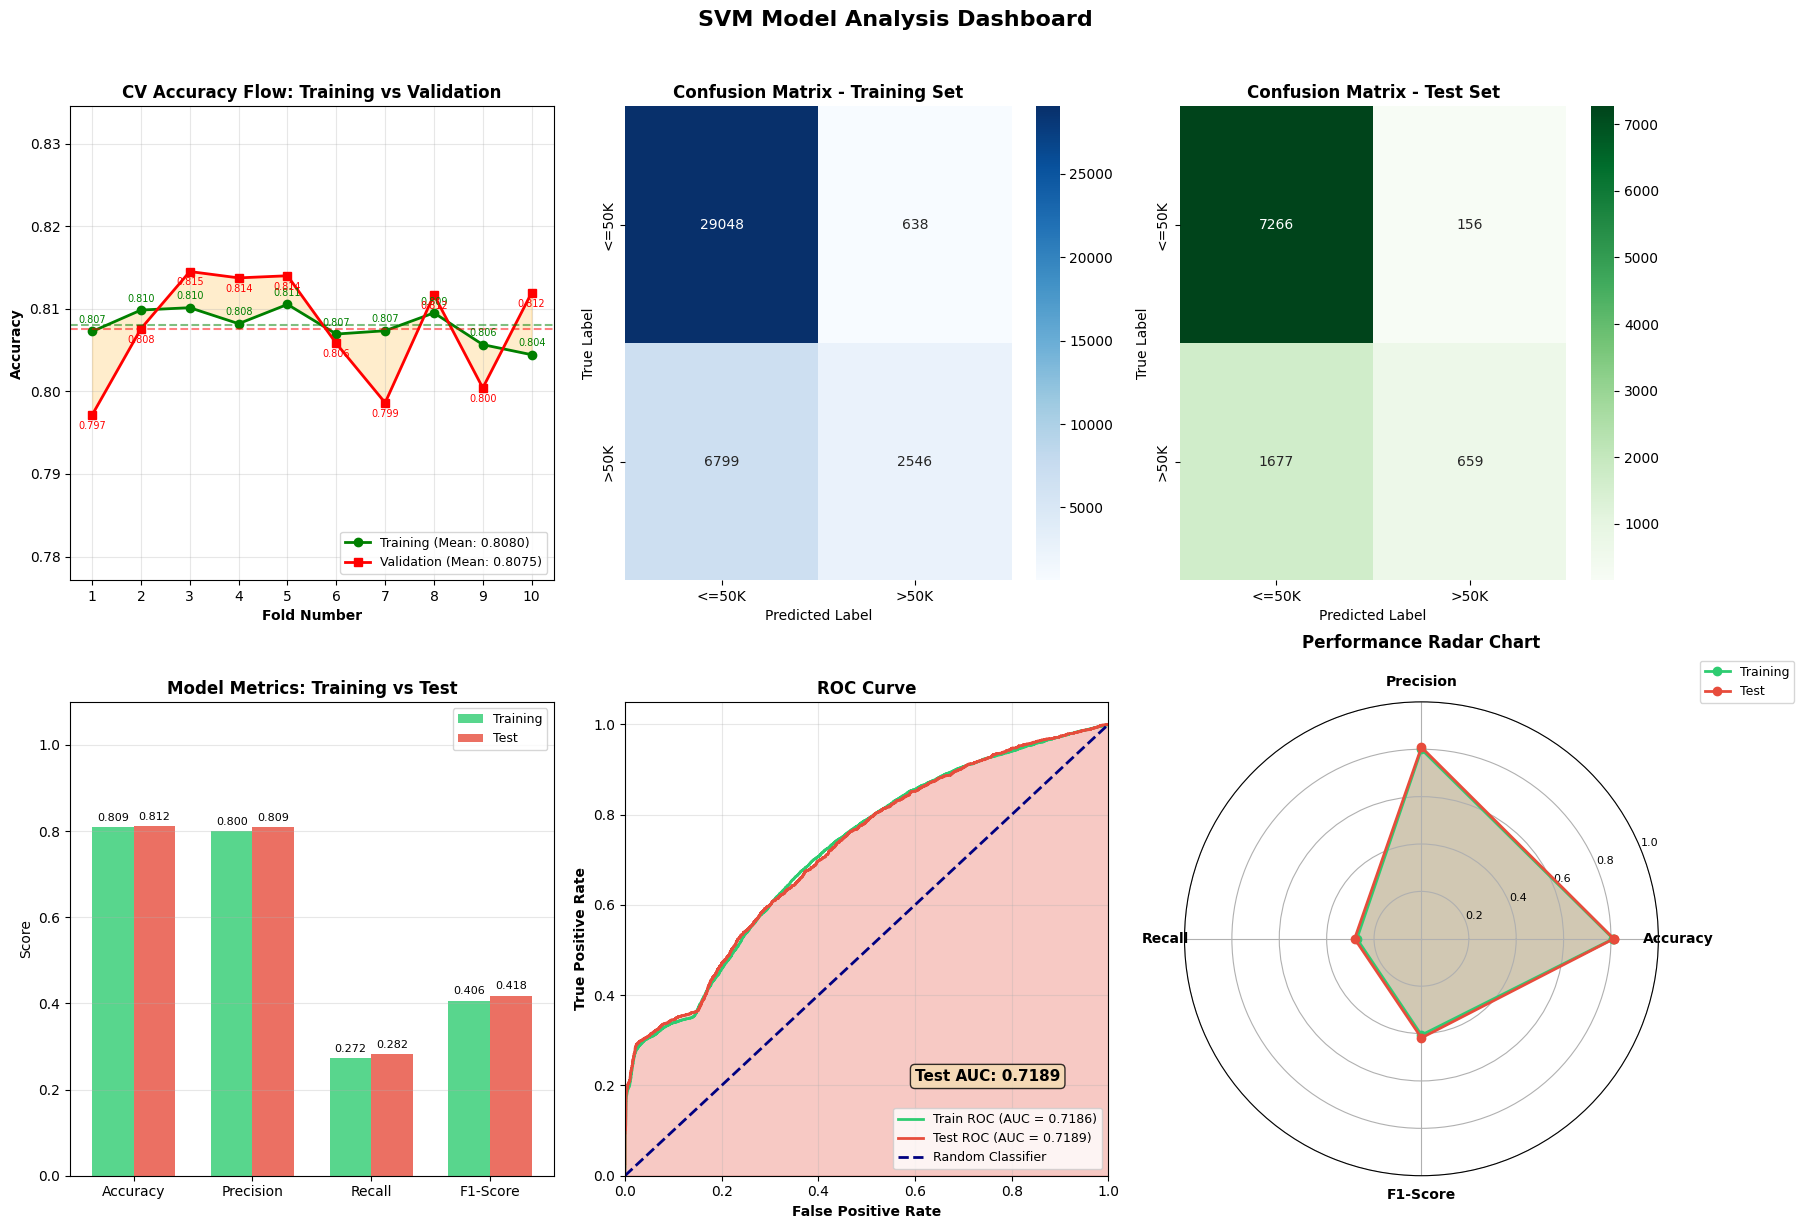

(LinearSVC(dual=False, max_iter=5000, random_state=3327),
 [0.8072422922538218,
  0.8098383056251424,
  0.8101229788203143,
  0.8081872010931451,
  0.810521521293555,
  0.8069346390343886,
  0.8073331815076292,
  0.809496697790936,
  0.8056536096561148,
  0.8044295149168754],
 [0.7971311475409836,
  0.8075839098129644,
  0.8145016653856009,
  0.8137330258775302,
  0.813989239046887,
  0.8057904176274661,
  0.7986164488854727,
  0.8116833205226749,
  0.8004099410709711,
  0.8119395336920318])

In [139]:
main(data_dir=data_dir)

  Fold 1: Train=0.8072 (green), Val=0.7971 (red)


  Fold 2: Train=0.8098 (green), Val=0.8076 (red)


  Fold 3: Train=0.8101 (green), Val=0.8145 (red)


  Fold 4: Train=0.8082 (green), Val=0.8137 (red)


  Fold 5: Train=0.8105 (green), Val=0.8140 (red)


  Fold 6: Train=0.8069 (green), Val=0.8058 (red)


  Fold 7: Train=0.8073 (green), Val=0.7986 (red)
  Fold 8: Train=0.8095 (green), Val=0.8117 (red)


CV Folds:  80%|███████████████████████████▏      | 8/10 [00:01<00:00,  4.44it/s]

  Fold 9: Train=0.8057 (green), Val=0.8004 (red)


CV Folds: 100%|█████████████████████████████████| 10/10 [00:02<00:00,  4.27it/s]

  Fold 10: Train=0.8044 (green), Val=0.8119 (red)


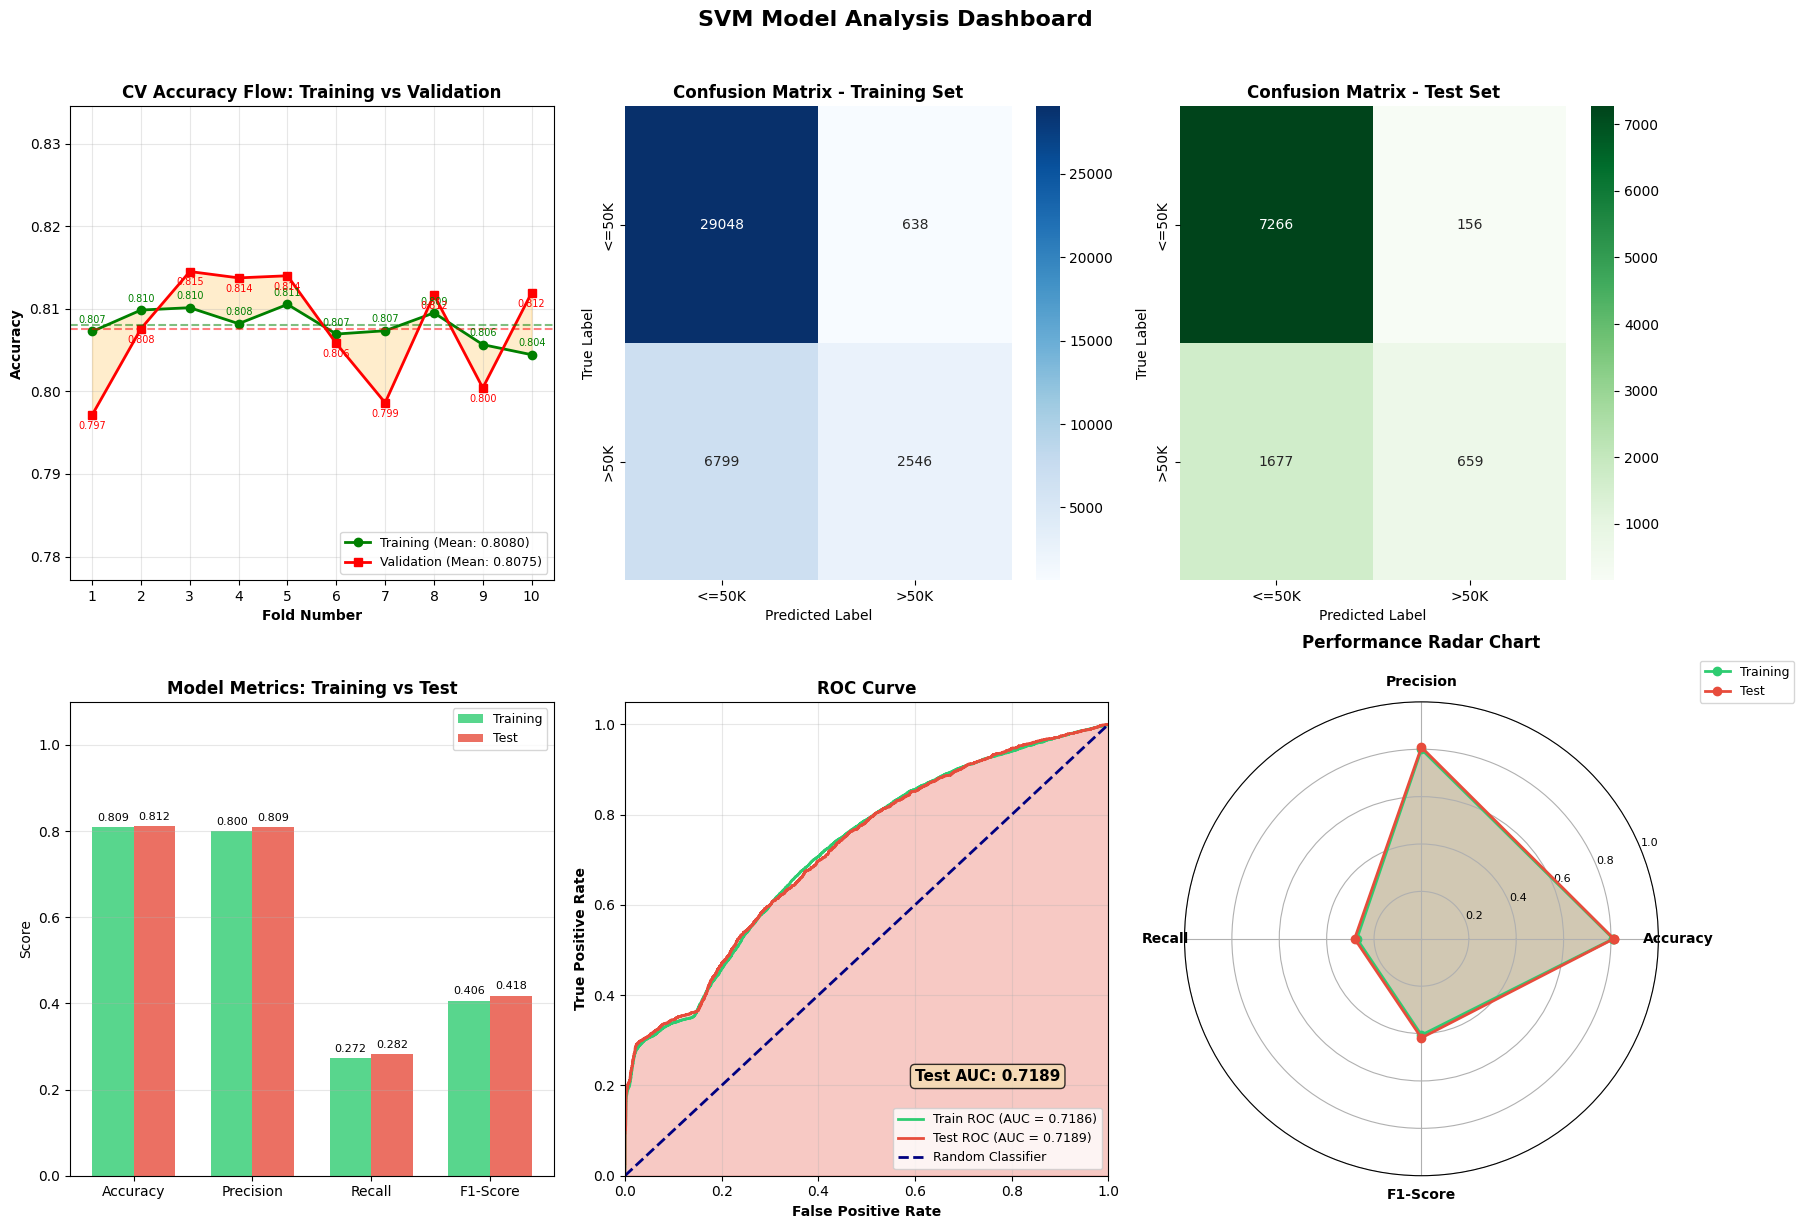

Model saved to: e:\adult-income-analysis\notebook\models\model.pkl


In [140]:
from joblib import dump

model_dir = os.path.join(notebook_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

svm_model, _, _ = main(data_dir=data_dir)
model_path = os.path.join(model_dir, "model.pkl")
dump(svm_model, model_path)
print(f"Model saved to: {model_path}")